In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix as sk_confusion_matrix
import pickle
import string
stopword = set(stopwords.words('english'))
warnings.filterwarnings("ignore")





In [ ]:
df=pd.read_csv("labeled_data.csv")

In [ ]:
df.shape

(24783, 7)

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


##### remove unwanted columns

In [ ]:
df.drop(columns=['Unnamed: 0','count','hate_speech','offensive_language','neither'],inplace=True)

In [ ]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
#checking null values
df.isnull().sum()

,0
class,0
tweet,0


In [ ]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [ ]:
def clean(c):
    c = str(c).lower()
    c = re.sub('\[.*?\]', '', c)
    c = re.sub('https?://\S+|www\.\S+', '', c)
    c = re.sub('<.*?>+', '', c)
    c = re.sub(r"\@w+|\#",'',c)
    c = re.sub(r"[^\w\s]",'',c)
    c = re.sub('[%s]' % re.escape(string.punctuation), '', c)
    c = re.sub('\n', '', c)
    c = re.sub('\w*\d\w*', '', c)
    return c

In [ ]:
def tokens(c):
    tweet_tokens = word_tokenize(c)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [ ]:
df['tweet'] = df['tweet'].apply(clean)
df['tweet'] = df['tweet'].apply(tokens)

In [ ]:
# removing duplicate data
df = df.drop_duplicates(subset=['tweet'])


In [ ]:
df.shape
print(df['tweet'].iloc[0],"\n")
print(df['tweet'].iloc[1],"\n")
print(df['tweet'].iloc[2],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 



In [ ]:
# Lemmatize the text data
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

In [ ]:
df['tweet'] = df['tweet'].apply(lemmatize_text)

In [ ]:
df['tweet'].iloc[67]

'allyhaaaaa lemmie eat oreo amp dish one oreo lol'

In [ ]:
df['class'].value_counts()

,count
class,
1,18984
2,4113
0,1409


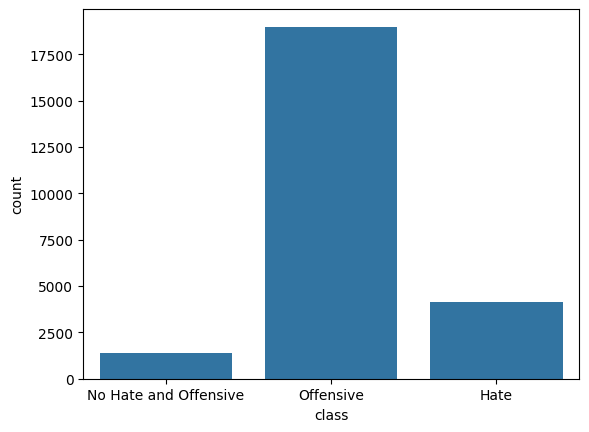

In [ ]:
plot = sns.countplot(x='class',data=df)
plot.set_xticklabels(['No Hate and Offensive','Offensive','Hate'])
plt.show()

In [ ]:
df.shape

(24506, 2)

In [ ]:
df1 = df.copy()

In [ ]:
#vectorizing the text data using TfidVectorizer and create a bigram lanuage model
vect=TfidfVectorizer(ngram_range=(1,2)).fit(df['tweet'])

In [ ]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 155680
First 200 features: 
 ['aa' 'aa class' 'aa lol' 'aaaaaaaaand' 'aaaaaaaaand begin' 'aaahhhhh'
 'aaahhhhh internet' 'aahahah' 'aahahah fuck' 'aaliyah' 'aaliyah curving'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhlovee' 'aaliyahhlovee yu'
 'aamaadmiparty' 'aamaadmiparty mix' 'aampt' 'aampt ackin' 'aamu']


In [ ]:
#separating the data into x and y to build the model
X = df['tweet']
Y = df['class']
X = vect.transform(X) #transforming the x data

In [ ]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [ ]:
models = {
    "Logisitic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Xgboost" : XGBClassifier(),
    "SVM": SVC(kernel='linear'),
}

In [ ]:
# Confusion matrix
def plot_confusion_matrix(Y_test, Y_test_pred, model_name):
    cm = sk_confusion_matrix(Y_test, Y_test_pred)
    labels = ['Hate Speech', 'Offensive Language', 'No Hate and Offensive']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [ ]:
# for model_name, model in models.items():
#     model.fit(X_train,Y_train)

#     Y_train_pred = model.predict(X_train)
#     Y_test_pred = model.predict(X_test)



#     #training set performance
#     model_train_accuracy = accuracy_score(Y_train,Y_train_pred)
#     model_test_accuracy = accuracy_score(Y_test,Y_test_pred)


#     print(model_name)
#     print("Model performance on training set")
#     print("- Accuracy:  {:.4f}".format(model_train_accuracy))
#     print(classification_report(Y_train, Y_train_pred))

#     print("-" * 70)

#     print("Model performance on test set")
#     print("- Accuracy:  {:.4f}".format(model_test_accuracy))
#     print(classification_report(Y_test, Y_test_pred))

#     print("=" * 70)
#     print("\n")

#     # Plot confusion matrix
#     plot_confusion_matrix(Y_test, Y_test_pred, model_name)



In [44]:
df.head()

,class,tweet
0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,rt boy dat coldtyga dwn bad cuffin dat hoe place
2,1,rt urkindofbrand dawg rt ever fuck bitch start...
3,1,rt cganderson vivabased look like tranny
4,1,rt shenikaroberts shit hear might true might f...


from matplotlib import pyplot as plt
_df_0['class'].plot(kind='hist', bins=20, title='class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('tweet').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['class'].plot(kind='line', figsize=(8, 4), title='class')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['tweet'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='class', y='tweet', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import string

X = df1['tweet']
Y = df1['class']

# Tokenize text
tokenizer = Tokenizer(num_words=10000)  # Set an appropriate number of words
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=300)  # Set maxlen as needed

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, Embedding, LSTM, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=X_train.shape[1]))  # Adjust dimensions
model.add(SpatialDropout1D(0.3))  # Increased dropout rate
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))  # Bidirectional LSTM with increased dropout
model.add(Dense(3, activation='softmax'))


In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test),
                     callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.8111 - loss: 0.5397
Epoch 1: val_accuracy improved from -inf to 0.89270, saving model to best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 302s 953ms/step - accuracy: 0.8112 - loss: 0.5393 - val_accuracy: 0.8927 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.9087 - loss: 0.2704
Epoch 2: val_accuracy improved from 0.89270 to 0.89474, saving model to best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 309s 924ms/step - accuracy: 0.9087 - loss: 0.2704 - val_accuracy: 0.8947 - val_loss: 0.2964 - learning_rate: 0.0010
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9298 - loss: 0.2020
Epoch 3: val_accuracy improved from 0.89474 to 0.89576, saving model to best_model.keras
307/307 ━━━━━━━━━━━━━━━━━━━━ 321s 921ms/step - accuracy: 0.9298 - loss: 0.2020 - val_accuracy: 0.8958 - val_loss: 0.3178 - learning_rate: 0.0010
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions and classification report
Y_test_pred = model.predict(X_test)
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)

print("Classification Report:\n", classification_report(Y_test, Y_test_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_test_pred_classes))

154/154 - 29s - 190ms/step - accuracy: 0.8947 - loss: 0.2964
Test Accuracy: 0.89
154/154 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.09      0.16       283
           1       0.92      0.95      0.94      3811
           2       0.80      0.89      0.84       808

    accuracy                           0.89      4902
   macro avg       0.75      0.65      0.65      4902
weighted avg       0.88      0.89      0.88      4902

Confusion Matrix:
 [[  26  226   31]
 [  22 3638  151]
 [   1   85  722]]


In [38]:
new_data = ["Facebook's mission is to give people the power to build community and bring the world closer together. We build social technologies to enable the best of what people can do together. Our principles are: give people a voice; serve everyone; promote economic opportunity; build connection and community; keep people safe and protect privacy. We recognize all people are equal in dignity and rights. We are all equally entitled to our human rights, without discrimination. Human rights are interrelated, interdependent, and indivisible."]

# Convert the single text into a sequence
new_sequences = tokenizer.texts_to_sequences(new_data)

# If you need padding
new_padded = pad_sequences(new_sequences, maxlen=300)

# Now you can use new_padded as input to your model
result = model.predict(new_padded)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


In [39]:
from keras.preprocessing.sequence import pad_sequences

# Define the new input data
new_data_1 = ["I hate you"]
new_data_2 = ["I love you"]
new_data_3 = ["I am not hate"]

# Step 1: Convert new data to sequences
new_sequences_1 = tokenizer.texts_to_sequences(new_data_1)
new_sequences_2 = tokenizer.texts_to_sequences(new_data_2)
new_sequences_3 = tokenizer.texts_to_sequences(new_data_3)

# Step 2: Pad the sequences to the same length as training data
new_padded_1 = pad_sequences(new_sequences_1, maxlen=300)
new_padded_2 = pad_sequences(new_sequences_2, maxlen=300)
new_padded_3 = pad_sequences(new_sequences_3, maxlen=300)

# Step 3: Make predictions using the model
result1 = model.predict(new_padded_1)
result2 = model.predict(new_padded_2)
result3 = model.predict(new_padded_3)

# Print the results
print("Result for 'I hate you':", result1)
print("Result for 'I love you':", result2)
print("Result for 'I am not hate':", result3)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Result for 'I hate you': [[0.17345488 0.51613563 0.3104095 ]]
Result for 'I love you': [[0.07341163 0.40545154 0.5211368 ]]
Result for 'I am not hate': [[0.17345488 0.51613563 0.3104095 ]]


In [40]:
# Load the best model
model.load_weights('best_model.keras')
model.save('final_model.keras')  # Save the best model as an h5 file

In [45]:
# Define the new input data for testing
hate_speech_example = ["rt mayasolovely woman shouldnt complain cleaning house amp man always take trash"]
offensive_example = ["You are so stupid, get a brain!"]
neutral_example = ["Everyone has a right to their own opinion."]

# Step 1: Convert new data to sequences
hate_speech_sequence = tokenizer.texts_to_sequences(hate_speech_example)
offensive_sequence = tokenizer.texts_to_sequences(offensive_example)
neutral_sequence = tokenizer.texts_to_sequences(neutral_example)

# Step 2: Pad the sequences to the same length as training data
hate_speech_padded = pad_sequences(hate_speech_sequence, maxlen=300)
offensive_padded = pad_sequences(offensive_sequence, maxlen=300)
neutral_padded = pad_sequences(neutral_sequence, maxlen=300)

# Step 3: Make predictions using the model
hate_speech_result = model.predict(hate_speech_padded)
offensive_result = model.predict(offensive_padded)
neutral_result = model.predict(neutral_padded)

# Print the results
print("Result for Hate Speech example:", hate_speech_result)
print("Result for Offensive example:", offensive_result)
print("Result for Neutral example:", neutral_result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Result for Hate Speech example: [[0.02664918 0.09009448 0.8832564 ]]
Result for Offensive example: [[0.08490945 0.24872833 0.6663622 ]]
Result for Neutral example: [[0.02321597 0.8370122  0.13977195]]


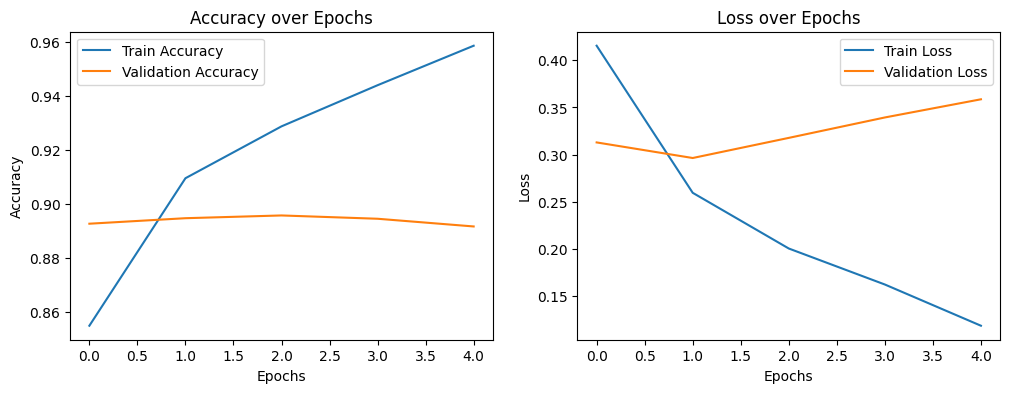

In [41]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()